In [ ]:
import json 
import pathlib
import Levenshtein as lev


In [ ]:

data_path = pathlib.Path("/srv/local2/estengel/uncertainty_data/vqa/")

val_ann_path = data_path.joinpath("v2_mscoco_val2014_annotations.json")
val_quest_path = data_path.joinpath("v2_OpenEnded_mscoco_val2014_questions.json")




In [ ]:
with open(val_ann_path) as f1, open(val_quest_path) as f2:
    val_anns = json.load(f1)
    val_quests = json.load(f2)



question_lookup = {e['question_id']: e for e in val_quests['questions']}

In [ ]:
import numpy as np 
import string 
from tqdm import tqdm 

def charify(s1, s2):
    """
    Levenshtein lib operates over strings of characters, rather than lists of strings
    It's really fast so we want to use it. This is a slightly hacky fix to do that.
    Given 2 lists of strings, get a joint vocab over them, then map each item in the vocab
    to a unique char. Replace the strings with chars, then concatenate. 
    """
    total_vocab = set(s1) | set(s2)
    chars = string.ascii_letters + string.digits + string.punctuation
    try:
        assert(len(total_vocab) < len(chars))
    except AssertionError:
        print("Warning: mapping incomplete, returning large distance to ignore in min")
        return np.inf
    chars = chars[0:len(total_vocab)]
    total_vocab = list(total_vocab)
    mapping = {k:c for k, c in zip(total_vocab, chars)}

    s1 = [mapping[x] for x in s1]
    s2 = [mapping[x] for x in s2]
    s1 = "".join(s1)
    s2 = "".join(s2)
    return (s1, s2, mapping)

def get_pairwise_lev(ann_set):

    scores = np.ones((len(ann_set), len(ann_set))) * np.inf
    for i, ann0 in enumerate(ann_set):
        for j, ann1 in enumerate(ann_set): 
            if i == j:
                scores[i,j] = 0.0
                continue
            c_ann0, c_ann1, mapping = charify(ann0.split(" "), ann1.split(" "))

            distance = lev.distance(c_ann0, c_ann1)
            scores[i,j] = distance
    return scores 

c = 0
all_dists_and_idxs = []
for i, annotation in tqdm(enumerate(val_anns['annotations'])):

    annotation_set = [x['answer'] for x in annotation['answers'] if x['answer_confidence'] == 'yes']
    pairwise_distances = get_pairwise_lev(annotation_set)
    # print([x['answer'] for x in annotation_set['answers']])
    mean_distance = np.mean(pairwise_distances, axis=0)
    mean_mean_distance = np.mean(mean_distance, axis=0)

    all_dists_and_idxs.append((i, mean_mean_distance))

    #if mean_mean_distance > 3:
    #    question = question_lookup[annotation['question_id']]
    #    print(question['question'])
    #    print(annotation_set)
    #    print(pairwise_distances)
    #    print(mean_mean_distance)
    #    c +=1 
        #if c > 10:
        #    break



sorted_dists = sorted(all_dists_and_idxs, key = lambda x:x[1])



## VQA Notes
The above code tries to identify high-disagreement examples by measuring the pairwise Levenshtein distance between each annotation, and isolating ones with a high distance. 

### Preliminary observations
High-distance pairs fall into a few groups: 
1. **color questions**:
    Questions like "What color is X" (where X is multi-colored). Annotators choose different colors. Example:
    ```What color is the plane?
    image id: 524011
    answers: ['blue', 'blue white and red', 'blue', 'light blue, dark blue, white, and red', 'blue white', 
            'blue', 'white, blue and red', 'blue', 'white and light blue', 'baby blue and white']```
    These questions aren't great, there isn't actually a lot of disagreement here, just lexical variation 
2. **text from a sign**: 
    Questions like "What does the sign say", where annotators vary in what they say/how they order it. Example:
    ```What do the road signs say?
       image id: 261273
       answers: ['stop, regulus st, stampede rd', 'stop', 'stampede, regulus, stop', 'stop', 
                 'stop, stampede, and regulus', 'regulus st, stampede rd', 'regulus st, stampede rd, and stop', 
                 'regulus stampede stop', 'stop']
    ``` 
    Example:
    ```
    What kinds of foods are available according to the sign?
    image id: 331688
    answers: ['italian', '4', 'sausage, hamburgers, hot dogs', 'meat', 'hamburgers, and hot dogs', 
              'italian sausage and beef, hamburgers, hot dogs', 'italian sausage combos, italian beef, hamburgers, hot dogs', 
              'fast food', 'meat']
    ```

3. **Underspecified referrents**:
    Some questions have multiple correct answers because the question makes a unique reference to a non-unique item (e.g. "what does this sign say" when there are 3 signs in the image, annotators choose differents signs to answer)

    Example: 
    ````
    What is this sign mean?
    image id: 331688
    answers: ['food available', '2 way traffic', '2 way street', 'it is restaurant menu', 'traffic goes both ways through construction']
    ```

4. **Why questions**: 
    Some questions ask for why something is, rather than what/how. Arguably, these are more commonsense inference questions than anything, and really don't require visual reasoning as much as they require world knowledge. Annotators give varying explanations. Example: 

    ```
    Why is there a stop sign on the bus towards the rear?
    image id: 130352
    answers: ['school bus', 'warning for others', 'to show people behind when not to pass bus', 'for cars to stop', 'yes', 'stop traffic for bus passenger', 'stop traffic', 'cars', 'for when kids get on']
    ```

    Example: 
    ```
    Why is the person stopped?
    image id: 261888
    answers: ['waiting', 'waiting for animals to pass', 'look at horses', 
              'to watch 2 horses in other lane', 'looking at horses', 'watching livestock', 'looking at something']
    ```




In [ ]:
# best = sorted_dists[0:10]
worst = sorted_dists[-20:]

for w, dist in worst:
    annotation = val_anns['annotations'][w]
    annotation_set = [x['answer'] for x in annotation['answers'] if x['answer_confidence'] == 'yes']
    question = question_lookup[annotation['question_id']]
    print(question['question'])
    print(f"image id: {annotation['image_id']}")
    print(annotation_set)
    print(dist)


# What about Glove
Levenshtein distance wasn't any good, how about using the mean glove embedding 

In [ ]:
from tqdm import tqdm 
import numpy as np 
import sys 
import pdb 
import re 

def get_glove(path):
    lookup = {}
    with open(path) as f1:
        for line in f1:
            splitline = re.split("\s+", line.strip())
            word = splitline[0]
            try:
                vec = np.array(splitline[1:], dtype=float) 
            except ValueError:
                continue
            lookup[word] = vec
    return lookup 
glove_lookup = get_glove("/srv/local1/estengel/resources/glove.840B.300d.txt")




In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
np.random.seed(12)

def get_glove_embedding(word):
    return glove_lookup[word]


def get_pairwise_glove(annotation_set):
    annotation_set_as_vec = []
    for i, ann in enumerate(annotation_set):
        ann = ann.split(" ")
        ann = [w for w in ann if w in glove_lookup.keys()]
        if len(ann) == 0:
            continue

        vecs = np.array([get_glove_embedding(word) for word in ann])
        annotation_set_as_vec.append(np.mean(vecs, axis=0) )

    if len(annotation_set) == 0 or len(annotation_set_as_vec) == 0:
        return np.zeros((1,1))

    annotation_set_as_vec = np.array(annotation_set_as_vec).reshape(-1, 300)
    # similarity_matrix = np.dot(annotation_set_as_vec.T, annotation_set_as_vec) / 2 * np.sum(annotation_set_as_vec, axis=0, keepdims=True)
    similarity_matrix = cosine_similarity(annotation_set_as_vec) 

    return similarity_matrix

glove_all_dists_and_idxs = []
for i, annotation in tqdm(enumerate(val_anns['annotations'])):

    annotation_set = [x['answer'] for x in annotation['answers'] if x['answer_confidence'] == 'yes']
    pairwise_similarity = get_pairwise_glove(annotation_set)
    mean_similarity = np.mean(pairwise_similarity, axis=0)
    mean_mean_similarity = np.mean(mean_similarity, axis=0)
    # print(pairwise_similarity)
    # print(mean_mean_similarity)
    glove_all_dists_and_idxs.append((i, mean_mean_similarity))
    # sys.exit()

In [ ]:
import seaborn as sns

values = [x[1] for x in glove_all_dists_and_idxs]
sns.histplot(values)


In [ ]:

# ignore numeric 
def is_not_numeric(idx):
    annotation = val_anns['annotations'][idx]
    annotation_set = [x['answer'] for x in annotation['answers'] if x['answer_confidence'] == 'yes']
    for ann in annotation_set:
        words = ann.split(" ")
        for w in words:
            if re.match("[0-9]+", w) is not None:
                return False
    return True

# filter by length 
def is_n_long(idx, min_len=5):
    annotation = val_anns['annotations'][idx]
    annotation_set = [x['answer'] for x in annotation['answers'] if x['answer_confidence'] == 'yes']

    if len(annotation_set) < min_len:
        return False
    return True 

glove_non_zero = [(i,x) for i,x in glove_all_dists_and_idxs if x > 0.0]
glove_no_nums = [(i,x) for i,x in glove_non_zero if is_not_numeric(i)]
removed_no_nums = len(glove_all_dists_and_idxs) - len(glove_no_nums)
print(f"removed {removed_no_nums} for numbers")
glove_min_len = [(i,x) for i,x in glove_no_nums if is_n_long(i)]
removed_min_len = len(glove_no_nums) - len(glove_min_len)
print(f"removed {removed_min_len} for being too short")
print(f"remaining: {len(glove_min_len)}")

sorted_dists = sorted(glove_min_len, key = lambda x:x[1])
worst = sorted_dists[0:20]

for w, dist in worst:
    annotation = val_anns['annotations'][w]
    annotation_set = [x['answer'] for x in annotation['answers'] if x['answer_confidence'] == 'yes']
    question = question_lookup[annotation['question_id']]
    print(question['question'])
    print(f"image id: {annotation['image_id']}")
    print(annotation_set)
    print(dist)

# What about glove
These look a lot better, but the current method gets the maximally different examples, where each annotator basically says something different. It looks like most of these examples are due to underspecification either in the image or question.

Example: Image has multiple posters/boxes with 2nd lines, so each annotator is right but has picked a different object. 
```Question: What are the words on the second line?
image id: 554838
Answers: ['magnum', 'hell', 'almendras', 'almendras', 'yes', 'corn flakes', 'magnum']```

In other examples, annotators pick different attributes to focus on. 

Example: (picture of an old RC Delorean) 
```What kind of car is that?
image id: 16838
['delorean', 'older one', 'lotus', 'toy', 'remote control model', 'delorean']
```
Some care that it's an old car, some car that it's RC, some care that it's a Delorean. 

## Other improvements
What about K-means to get fixed number of clusters, then order by most coherent clusters. That way I can say, "Give me the examples that have K distinct answers of clusters, with annotators going one of two ways" and set K to 2 or 3


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
np.random.seed(12)
K = 2
kmeans_wrapper = KMeans(n_clusters=K, random_state=12)

def get_glove_embedding(word):
    return glove_lookup[word]

def get_kmeans_glove(annotation_set):
    annotation_set_as_vec = []
    for i, ann in enumerate(annotation_set):
        ann = ann.split(" ")
        ann = [w for w in ann if w in glove_lookup.keys()]
        if len(ann) == 0:
            continue

        vecs = np.array([get_glove_embedding(word) for word in ann])
        annotation_set_as_vec.append(np.mean(vecs, axis=0) )

    if len(annotation_set) == 0 or len(annotation_set_as_vec) < 3:
        return np.inf, [], -1

    annotation_set_as_vec = np.array(annotation_set_as_vec).reshape(-1, 300)
    # run kmeans
    kmeans = kmeans_wrapper.fit(annotation_set_as_vec) 
    # intertia is sum of squared distances of samples to their closest cluster center 
    # high intertia means dispersed, low means fits well to the number of clusters
    centers = kmeans.predict(annotation_set_as_vec) 
    num_centers = len(set(centers))
    if num_centers < 2:
        # ignore examples where everyone agrees on the same answer
        inertia = np.inf
        center_score = 0.0
    else:
        inertia = kmeans.inertia_    
        # score based on how balanced centers is 
        balance_center = 0.5
        center_mean = np.mean(centers)
        center_score = -2*np.abs(center_mean - balance_center) + 1
    return inertia, centers, center_score


kmeans_dists_and_idxs = []
for i, annotation in tqdm(enumerate(val_anns['annotations'])):

    annotation_set = [x['answer'] for x in annotation['answers'] if x['answer_confidence'] == 'yes']
    kmeans_distance, kmeans_centers, center_score = get_kmeans_glove(annotation_set)
    kmeans_dists_and_idxs.append((i,  kmeans_distance))

    if i > 1000:
        sys.exit()

In [ ]:
sorted_dists = sorted(kmeans_dists_and_idxs, key = lambda x:x[1])
worst = sorted_dists[0:20]

for w, dist in worst:
    annotation = val_anns['annotations'][w]
    annotation_set = [x['answer'] for x in annotation['answers'] if x['answer_confidence'] == 'yes']
    question = question_lookup[annotation['question_id']]
    print(question['question'])
    print(f"image id: {annotation['image_id']}")
    print(annotation_set)
    print(dist)

# Related idea: 
A K-means-based score for how "hard" an example is 

given by 

$$ \min\limits_{k\in \{1, ..., M\}} \big( \sum\limits_{x \in X} (C(x) - x)^2 + k^t \big) $$ 
where $t$ is a hyperparam and $C(x)$ is the centroid for datapoint $x$

In [ ]:

kmeans_wrapper_dict = {k: KMeans(n_clusters=k, random_state=12) for k in range(0, 10)}


def get_kmeans_score(annotation_set, penalty_factor = 2):
    annotation_set_as_vec = []
    for i, ann in enumerate(annotation_set):
        ann = ann.split(" ")
        ann = [w for w in ann if w in glove_lookup.keys()]
        if len(ann) == 0:
            continue

        vecs = np.array([get_glove_embedding(word) for word in ann])
        annotation_set_as_vec.append(np.mean(vecs, axis=0) )


    if len(annotation_set_as_vec) == 0: 
        return None

    annotation_set_as_vec = np.array(annotation_set_as_vec).reshape(-1, 300)
    scores_and_num_centers = []

    for k in range(1, annotation_set_as_vec.shape[0]):
        kmeans_wrapper = kmeans_wrapper_dict[k]    
        # run kmeans
        kmeans = kmeans_wrapper.fit(annotation_set_as_vec) 
        centers = kmeans.predict(annotation_set_as_vec) 
        num_centers = len(set(centers))
        # intertia is sum of squared distances of samples to their closest cluster center 
        score = kmeans.inertia_ + num_centers ** penalty_factor
        # high intertia means dispersed, low means fits well to the number of clusters
        scores_and_num_centers.append((score, kmeans.inertia_, num_centers))
        # if you hit zero inertia, no sense in going further 
        if kmeans.inertia_ < 1e-16:
            break

    score_array = np.array(scores_and_num_centers)
    min_row = np.argmin(score_array[:,0])
    return score_array[min_row, :]

examples_by_kmeans_score = []
penalty_factor = 2
for i, annotation in tqdm(enumerate(val_anns['annotations'])):

    annotation_set = [x['answer'] for x in annotation['answers'] if x['answer_confidence'] == 'yes']
    kmeans_score =  get_kmeans_score(annotation_set, penalty_factor)
    if kmeans_score is None:
        continue
    examples_by_kmeans_score.append((i,  kmeans_score))


In [ ]:
sorted_dists = sorted(examples_by_kmeans_score, key = lambda x:x[1][0])
lowest = sorted_dists[0:20]

for w, dist in lowest:
    annotation = val_anns['annotations'][w]
    annotation_set = [x['answer'] for x in annotation['answers'] if x['answer_confidence'] == 'yes']
    question = question_lookup[annotation['question_id']]
    print(question['question'])
    print(f"image id: {annotation['image_id']}")
    print(annotation_set)
    print(dist)




In [ ]:
highest = sorted_dists[-20:]

for w, dist in highest:
    annotation = val_anns['annotations'][w]
    annotation_set = [x['answer'] for x in annotation['answers'] if x['answer_confidence'] == 'yes']
    question = question_lookup[annotation['question_id']]
    print(question['question'])
    print(f"image id: {annotation['image_id']}")
    print(annotation_set)
    print(f"score: {dist[0]}, inertia: {dist[1]}, n_clusters: {dist[2]}")

In [ ]:
len(glove_lookup)

In [ ]:
import pathlib 
import json
import pandas as pd 
import seaborn as sns 
from matplotlib import pyplot as plt 

from kmeans import get_kmeans_score, get_glove


glove_lookup = get_glove("/srv/local1/estengel/resources/glove.840B.300d.txt") 





In [ ]:
from kmeans import ArgumentWrapper, make_training_example
from tqdm import tqdm 
from sklearn.cluster import KMeans
import numpy as np

def get_kmeans_score_inertia(annotation_set, glove_lookup, kmeans_wrapper_dict, reduction='mean'):
    annotation_set_as_vec = []
    for i, ann in enumerate(annotation_set):
        ann = ann.split(" ")
        ann = [w for w in ann if w in glove_lookup.keys()]
        if len(ann) == 0:
            continue

        vecs = np.array([glove_lookup[word] for word in ann])
        if reduction == 'mean': 
            # mean pool
            annotation_set_as_vec.append(np.mean(vecs, axis=0) )
        elif reduction == 'max':
            # max pool
            annotation_set_as_vec.append(np.max(vecs, axis=0) )
        else:
            print(f'invalid reduction {reduction}')
            exit()

    if len(annotation_set_as_vec) == 0: 
        return None

    annotation_set_as_vec = np.array(annotation_set_as_vec).reshape(-1, 300)
    scores_and_num_centers = []

    inertia_by_means = {}

    for k in range(1, annotation_set_as_vec.shape[0]):
        kmeans_wrapper = kmeans_wrapper_dict[k]    
        # run kmeans
        kmeans = kmeans_wrapper.fit(annotation_set_as_vec) 
        centers = kmeans.predict(annotation_set_as_vec) 
        num_centers = len(set(centers))
        # intertia is sum of squared distances of samples to their closest cluster center 
        inertia_by_means[k] = kmeans.inertia_

        if kmeans.inertia_ < 1e-16:
            break

    return inertia_by_means


kmeans_wrapper_dict = {k: KMeans(n_clusters=k, random_state=12) for k in range(0, 10)}
annotation_path = "/srv/local2/estengel/annotator_uncertainty/vqa/v2_mscoco_val2014_annotations.json"
question_path = "/srv/local2/estengel/annotator_uncertainty/vqa/v2_OpenEnded_mscoco_val2014_questions.json"
with open(annotation_path) as f1, open(question_path) as f2:
    all_anns = json.load(f1)
    all_quests = json.load(f2)
question_lookup = {e['question_id']: e for e in all_quests['questions']}

print(f"building arg wrappers")
num_examples = 10
all_anns['annotations'] = all_anns['annotations'][0:num_examples]
    
arg_wrappers = [ArgumentWrapper(annotation, question_lookup, glove_lookup, kmeans_wrapper_dict, 0, "max") for annotation in all_anns['annotations']]

print(arg_wrappers)
to_plot = pd.DataFrame(columns=["k", "inertia"], dtype=float)

for wrap in tqdm(arg_wrappers):
    annotation = wrap.annotation
    inner_glove_lookup = wrap.glove_lookup 
    kmeans_wrapper_dict = wrap.kmeans_wrapper_dict 
    penalty_factor = wrap.penalty_factor 
    question = wrap.question 
    reduction = wrap.reduction

    image_id = annotation['image_id']
    annotation_set = [x['answer'] for x in annotation['answers'] if x['answer_confidence'] == 'yes']
    inertia =  get_kmeans_score_inertia(annotation_set, inner_glove_lookup, kmeans_wrapper_dict, reduction) 
    print(annotation_set)
    print(inertia)
    break
    # if inertia is None:
    #     continue

#     for k in inertia.keys():
#         to_plot = to_plot.append({"k": k, "inertia": inertia[k]}, ignore_index=True)

# sns.lineplot(data=to_plot, x = "k", y = "inertia")
# print(to_plot)

In [3]:
import json 
with open('/srv/local2/estengel/annotator_uncertainty/vqa/val_kmeans_penalty_100.0_max.json') as f1:
    data = json.load(f1)



In [4]:
filtered_data = [x for x in data if x['num_clusters'] == 2 and len(x['annotation_set']) > 5] 
sorted_data = sorted(filtered_data, key = lambda x: x['difference_penalty'])

something
question: What is the man doing in the street?
answers: crossing it, walking, walking, crossing, crossing road, walking, crossing, walking, crossing, walking


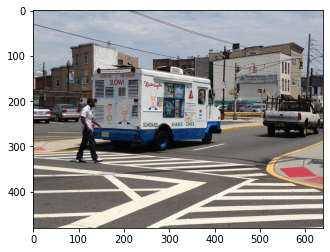

question: Is it still snowing in the picture?
answers: yes, yes, no, yes, no, yes, no, no


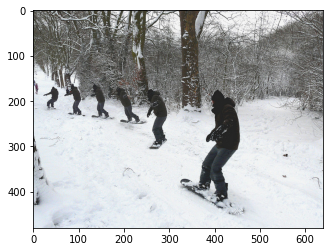

question: Does the man have goggles on?
answers: yes, no, no, yes, no, no, yes, yes


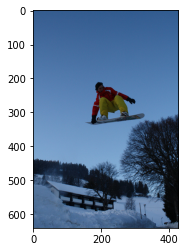

question: What color is the bike on the right?
answers: green, silver, and black, green and silver, silver and sea foam green, gray, gray, green


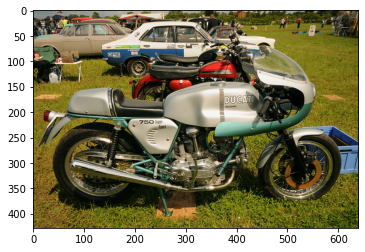

question: What is the woman in the room doing?
answers: talking to someone, talking, talking, talking to someone outside of window, talking, talking out window


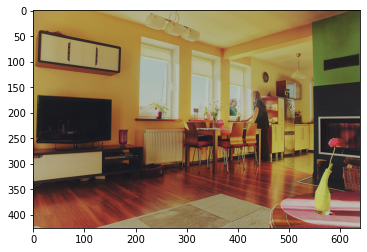

question: Is the girl's part in her hair even?
answers: yes, yes, no, yes, no, no, no, yes


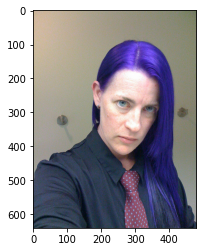

question: What is he sitting on?
answers: couch, sofa, sofa, chair, chair, couch, couch, chair, chair, chair


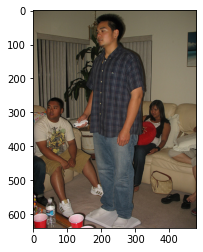

KeyboardInterrupt: Interrupted by user

In [6]:

from matplotlib import pyplot as plt 
import pathlib
from cv2 import imshow, imread, waitKey, destroyAllWindows
image_root = pathlib.Path("/srv/local2/estengel/annotator_uncertainty/vqa/val2014")

def get_image_fname(num):
    num_digits = len("000000264110")
    n = len(str(num))
    n_zeros = num_digits-n
    zeros = "".join(['0'] * n_zeros)
    name = f"COCO_val2014_{zeros}{num}.jpg"
    return name

print("something")
with open("examples.json","w") as f1:
    for i in range(300):
        small_data = sorted_data[i]
        print(f"question: {small_data['question']['question']}")
        print(f"answers: {', '.join(small_data['annotation_set'])}")
        image_path = image_root.joinpath(get_image_fname(small_data['image_id']))
        image = plt.imread(str(image_path))
        plt.imshow(image)
        plt.show()
        code = input("keep? [y/N]")
        if code == "y": 
            f1.write(json.dumps(small_data, indent=4) + "\n")
        else:
            pass 